In [1]:
import scipy.stats as sps
from scipy.interpolate import interp1d
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from CMF_Predictor import CMFRecommender
from tqdm import tqdm
from libmf import mf

Using file found in /home/liliya/2024-Project-144/code/venv/lib/python3.10/site-packages:
/home/liliya/2024-Project-144/code/venv/lib/python3.10/site-packages/libmf.cpython-310-x86_64-linux-gnu.so


In [2]:
def usefulness(c, w, noice):
    return np.arctan(c - w + noice) / np.pi + 0.5

In [3]:
customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)


class Distribution_Handler:
    def __init__(self, distribution):
        self.distribution = distribution

    def rvs(self, size=1):
        if issubclass(type(self.distribution), sps.rv_continuous):
            return self.distribution.rvs(size)
        else:
            return self.distribution.resample(size)[0]


In [16]:
def interpol_distribution(sample):
    hst = np.histogram(sample, density=True, bins=200)
    return interp1d(hst[1][:-1], hst[0], kind='linear',
                    fill_value=0.0, bounds_error=False)

In [4]:
def zero_step(model: CMFRecommender, user_info, item_info, topn=52):
    new_feedback = []

    maximal_user, maximal_item = model.get_max_index()
    old_users = model.get_known_users_info().set_index("UserId")

    for i in range(topn):
        user_id = np.random.choice(round(maximal_user) - 1)
        for index, item_row in item_info.iterrows():
            deal = sps.bernoulli.rvs(
                usefulness(old_users.loc[user_id]["F"], item_row["F"], epsilon.rvs()))  # моделируем сделки
            new_feedback.append((user_id, item_row["ItemId"], deal))

    for index, user_row in user_info.iterrows():
        w_offered = model.recommend_items_cold(user_row["F"], topn)["ItemId"]
        for w in w_offered:
            deal = sps.bernoulli.rvs(usefulness(user_row["F"], w, epsilon.rvs()))  # моделируем сделки
            new_feedback.append((user_row["UserId"], w, deal))

    model.retrain(new_feedback, user_info, item_info)
    return model


In [14]:
def print_distributions(num_of_iteration, axs, user_info, item_info):
    sns.kdeplot(user_info["F"], ax=axs[0], label=f"Itration number = {num_of_iteration}")
    axs[0].set_title("User Distribution")
    sns.kdeplot(data=item_info["F"], ax=axs[1])
    axs[1].set_title("Item Distribution")

In [5]:
def dynamic_system_iterate(model: CMFRecommender, customer_distribution, w_distribution, c_size=10, w_size=10,
                           num_of_steps=5,
                           topn=5, delta=0.00001, visualize_distributions=None):
    maximal_user, maximal_item = model.get_max_index()
    user_info = pd.DataFrame(
        {"F": customer_distribution.rvs(size=c_size)})  # size = (c_size, c_feature_size) в многомерном случае 
    user_info["UserId"] = np.arange(maximal_user + 1, maximal_user + 1 + c_size)

    item_info = pd.DataFrame(
        {"F": w_distribution.rvs(size=w_size)})  # size = (w_size, w_feature_size) в многомерном случае 
    item_info["ItemId"] = np.arange(maximal_item + 1, maximal_item + 1 + w_size)
    model = zero_step(model, user_info, item_info, topn=topn)

    if visualize_distributions is not None:
        print_distributions(visualize_distributions[0], visualize_distributions[1], user_info, item_info)

    new_feedback = []
    hit = False
    counter = 0
    for step in range(1, num_of_steps + 1):
        for index, user_row in user_info.iterrows():
            w_offered = model.recommend_items(user_row["UserId"], item_info['ItemId'], topn=topn, exclude_rated=True)[
                "ItemId"]
            for w in w_offered:
                deal = sps.bernoulli.rvs(usefulness(user_row["F"], w, epsilon.rvs()))  # моделируем сделки
                counter += deal
                new_feedback.append((user_row["UserId"], w, deal))

        model.retrain(new_feedback, [], [])

    # смена распределения
    new_feedback_df = pd.DataFrame(new_feedback, columns=['UserId', 'ItemId', 'Feedback'])
    new_feedback_df["Feedback"] += delta
    grouped_users = new_feedback_df.groupby('UserId')['Feedback'].mean().reset_index()

    user_info = user_info.merge(grouped_users, how="inner", on='UserId')

    customer_distribution = Distribution_Handler(sps.gaussian_kde(user_info["F"], weights=user_info['Feedback']))
    grouped_items = new_feedback_df.groupby('ItemId')['Feedback'].mean().reset_index()
    # grouped_items['Feedback'] += delta

    item_info = item_info.merge(grouped_items, how="inner", on='ItemId')

    w_distribution = Distribution_Handler(sps.gaussian_kde(item_info["F"], weights=item_info['Feedback']))

    return customer_distribution, w_distribution, float(counter) / c_size



In [10]:

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=1000)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(1000)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=1000)})
item_info["ItemId"] = np.arange(1000)
feedback = []

# print_distributions(0, axs,user_info, item_info)

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))


In [11]:
model = CMFRecommender(capacity=10000)
model.fit(feedback, user_info, item_info)

In [12]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution

In [25]:
 # new_cust_distr, new_w_distr, _ = dynamic_system_iterate(model, new_cust_distr, new_w_distr, c_size=10, w_size=10, visualize_distributions=True)

100%|██████████| 10/10 [09:24<00:00, 56.40s/it]
/tmp/ipykernel_9362/4233865308.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


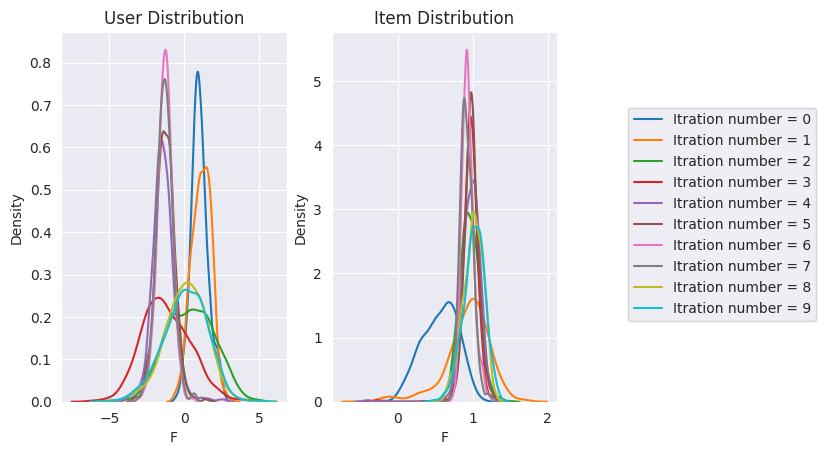

In [20]:
big_steps = 10
hit_metrics = []
curr_hit = 0
fig, axs = plt.subplots(ncols=2)
for i in tqdm(range(big_steps)):
    # if (i + 1) % 5 == 0:
    new_cust_distr, new_w_distr, curr_hit = dynamic_system_iterate(model, new_cust_distr, new_w_distr, c_size=1000,
                                                                   w_size=1000, visualize_distributions=(i, axs))
    # else:
    #     new_cust_distr, new_w_distr, curr_hit = dynamic_system_iterate(i, axs, model, new_cust_distr, new_w_distr, c_size=50,
    #                                                                    w_size=50, visualize_distributions=False)
    hit_metrics.append(curr_hit)

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

100%|██████████| 5/5 [01:05<00:00, 13.18s/it]


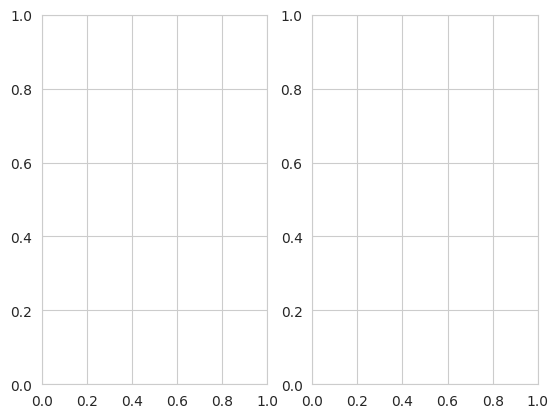

In [11]:
big_steps = 5
hit_metrics = []
curr_hit = 0
fig, axs = plt.subplots(ncols=2)
for i in tqdm(range(big_steps)):
    # if (i + 1) % 5 == 0:
    new_cust_distr, new_w_distr, curr_hit = dynamic_system_iterate(i, axs, model, new_cust_distr, new_w_distr,
                                                                   c_size=50, w_size=50, visualize_distributions=False)
    # else:
    #     new_cust_distr, new_w_distr, curr_hit = dynamic_system_iterate(i, axs, model, new_cust_distr, new_w_distr, c_size=50,
    #                                                                    w_size=50, visualize_distributions=False)
    hit_metrics.append(curr_hit)



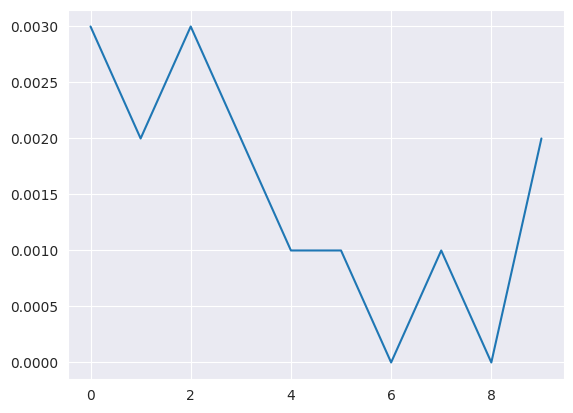

In [21]:
plt.plot(np.arange(big_steps), hit_metrics)